# Evaluated MobileNetV2's performance after training.

- Author: Ankita Jaswal

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from sklearn import model_selection
from math import ceil
import cv2
import tensorflow as tf

In [ ]:
img_array=cv2.imread("/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/Datasets/train_data_processed/surprise/35875.jpg")

In [ ]:
img_array.shape

(48, 48, 3)

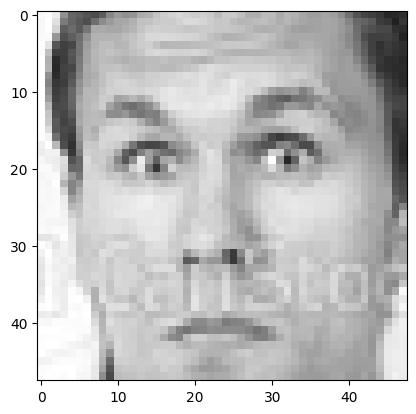

In [ ]:
plt.imshow(img_array)

In [ ]:
datadirectory="/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/Datasets/train_data_processed"

In [ ]:
classes=["surprise","sad","neutral","happy","fear","disgust","angry"]

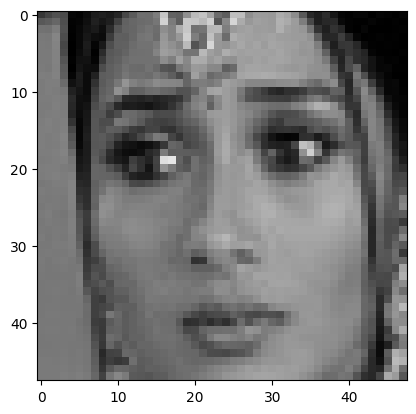

In [ ]:
for category in classes:
  path=os.path.join(datadirectory,category)
  for img in os.listdir(path):
    img_array=cv2.imread(os.path.join(path,img))
    plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))
    plt.show()
    break
  break

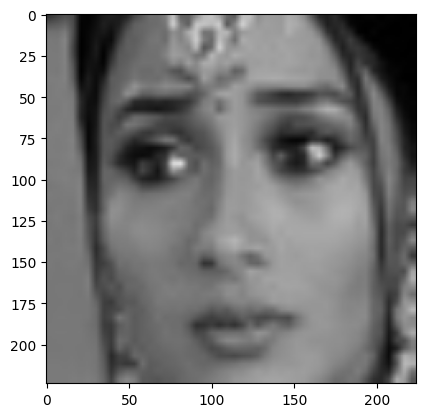

In [ ]:
img_size=224
new_array=cv2.resize(img_array,(img_size,img_size))
plt.imshow(cv2.cvtColor(new_array,cv2.COLOR_BGR2RGB))

convert images to array

In [ ]:
from logging import exception
training_data=[]
def create_training_data():
  for category in classes:
    path=os.path.join(datadirectory, category)
    class_num=classes.index(category)
    for img in os.listdir(path):
      try:
        img_array=cv2.imread(os.path.join(path,img))
        new_array=cv2.resize(img_array,(img_size,img_size))
        training_data.append([new_array,class_num])
      except exception as e:
        pass
  return training_data

In [ ]:
train_data = create_training_data()

In [ ]:
import joblib

# save train data for mobilenet
save_path = '/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/MobileNet/train_data.joblib'
joblib.dump(train_data, save_path)

['/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/MobileNet/train_data.joblib']

In [ ]:
data = joblib.load(save_path)

In [ ]:
print(len(data))

31189


In [ ]:
import random
random.shuffle(data)

In [ ]:
x=[]
y=[]
for features,label in data:
  x.append(features)
  y.append(label)
# Convert list x to numpy array
x=np.array(x).reshape(-1,img_size,img_size,3)

In [ ]:
x.shape

(31189, 224, 224, 3)

In [ ]:
# Convert list y to numpy array
y=np.array(y)

In [ ]:
y.shape

(31189,)

### Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (80% training, 20% validation)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y)



In [ ]:
print("Training Data:")
print("Features (x_train):", x_train.shape)
print("Labels (y_train):", y_train.shape)

print("\nValidation Data:")
print("Features (x_val):", x_val.shape)
print("Labels (y_val):", y_val.shape)


Training Data:
Features (x_train): (24951, 224, 224, 3)
Labels (y_train): (24951,)

Validation Data:
Features (x_val): (6238, 224, 224, 3)
Labels (y_val): (6238,)


# Model training-transfer learning using MobileNetV2 and training for emotion recognition task

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model=tf.keras.applications.MobileNetV2()

14536120/14536120 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [ ]:
base_input=model.layers[0].input
base_output=model.layers[-2].output

In [ ]:
base_output

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>

In [ ]:
final_output=layers.Dense(128)(base_output)
final_output=layers.Activation('relu')(final_output)
final_output=layers.Dense(64)(final_output)
final_output=layers.Activation('relu')(final_output)
final_output=layers.Dense(7,activation='softmax')(final_output)

In [ ]:
final_output

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'dense_2')>

In [ ]:
new_model=keras.Model(inputs=base_input,outputs=final_output)

In [ ]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

### Learning Rate Scheduler and Early Stopping for training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Set up EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)


### for scheduler, starts decaying exponentionally after 10 epochs

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Set up LearningRateScheduler
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Set up ModelCheckpoint
checkpoint = ModelCheckpoint(
    '/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/model_data/mobilenetv2_checkpoint.h5',
    monitor='val_loss',            # Monitor the validation loss
    verbose=1,                     # Logging level
    save_best_only=True,           # Save only the best model
    save_weights_only=False,       # If True, only weights are saved
    mode='auto',                   # Auto mode means the direction is inferred
    save_freq='epoch'              # Save after each epoch
)


In [ ]:
EPOCHS = 20

# Compile model
new_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with callbacks
history = new_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=32,
    callbacks=[checkpoint, early_stopping, lr_scheduler]
)



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
780/780 [==============================] - ETA: 0s - loss: 1.2892 - accuracy: 0.5166
Epoch 1: val_loss improved from inf to 2.78078, saving model to /content/drive/Shareddrives/CMPE 258 - Deep Learning Project/model_data/mobilenetv2_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


780/780 [==============================] - 76s 59ms/step - loss: 1.2892 - accuracy: 0.5166 - val_loss: 2.7808 - val_accuracy: 0.4203 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/20
779/780 [============================>.] - ETA: 0s - loss: 1.0824 - accuracy: 0.5909
Epoch 2: val_loss did not improve from 2.78078
780/780 [==============================] - 44s 56ms/step - loss: 1.0825 - accuracy: 0.5909 - val_loss: 4.8079 - val_accuracy: 0.2159 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/20
779/780 [============================>.] - ETA: 0s - loss: 0.9935 - accuracy: 0.6268
Epoch 3: val_loss did not improve from 2.78078
780/780 [==============================] - 40s 51ms/step - loss: 0.9936 - accuracy: 0.6268 - val_loss: 6.0878 - val_accuracy: 0.1811 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/20
780/780 [================

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


[0.5165724754333496, 0.5909181833267212, 0.6267884969711304, 0.6545228362083435, 0.6721975207328796, 0.702376663684845, 0.7275860905647278, 0.7600497007369995, 0.7945172786712646, 0.831750214099884]
[0.4203270375728607, 0.21593458950519562, 0.18114779889583588, 0.4057390093803406, 0.3081115782260895, 0.5394357442855835, 0.5349470973014832, 0.5001603364944458, 0.6059634685516357, 0.6173452734947205]
[1.2891507148742676, 1.082470417022705, 0.9935959577560425, 0.932319700717926, 0.8830210566520691, 0.8084486126899719, 0.7289093732833862, 0.6533641219139099, 0.5656903386116028, 0.4732896089553833]
[2.7807798385620117, 4.8078813552856445, 6.0878119468688965, 2.3799221515655518, 3.3508784770965576, 1.4430373907089233, 1.3337763547897339, 1.8162959814071655, 1.367175579071045, 1.3651963472366333]


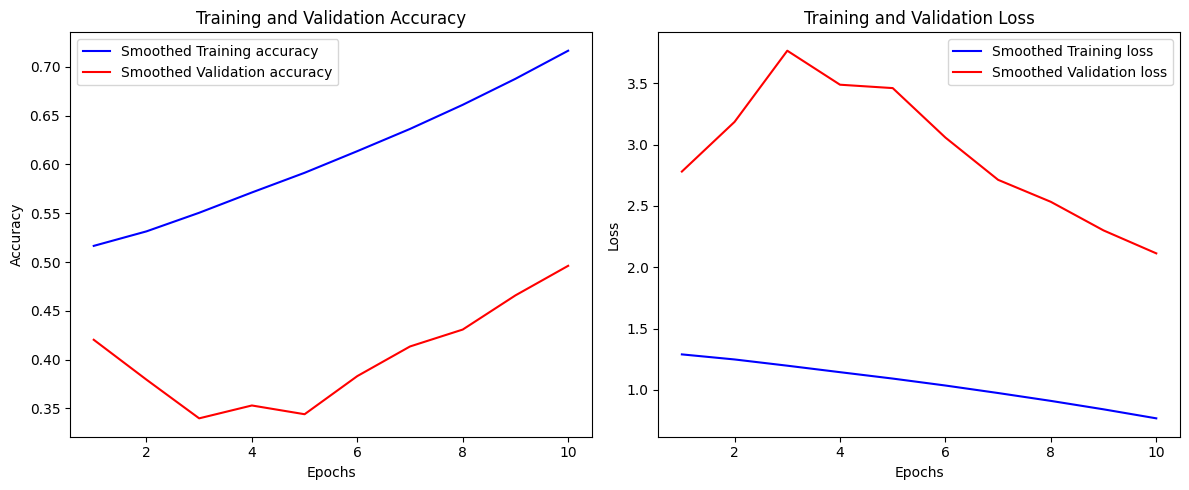

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print(acc)
print(val_acc)
print(loss)
print(val_loss)

smooth_acc = smooth_curve(acc)
smooth_val_acc = smooth_curve(val_acc)
smooth_loss = smooth_curve(loss)
smooth_val_loss = smooth_curve(val_loss)

epochs = range(1, len(acc) + 1)

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, smooth_acc, 'b', label='Smoothed Training accuracy')
plt.plot(epochs, smooth_val_acc, 'r', label='Smoothed Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, smooth_loss, 'b', label='Smoothed Training loss')
plt.plot(epochs, smooth_val_loss, 'r', label='Smoothed Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



Can't attempt to cross validate best hyperparams, not enough memory for GPU, limited to 16 GBs and it's capped out.

In [ ]:
new_model.save("/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/model_data/mobilenet_12-1-2023.h5")

# Evaluate Performance

In [ ]:
new_model=tf.keras.models.load_model("/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/model_data/mobilenet_newmodel.h5")

In [ ]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 32.1 MB/s eta 0:00:00


In [ ]:
from mtcnn import MTCNN
import cv2

# Initialize MTCNN
detector = MTCNN()

# Load your image
frame=cv2.imread("/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/Datasets/train_data/surprise/35875.jpg")
image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Detect faces
faces = detector.detect_faces(image_rgb)


In [ ]:
face_images = []

for face in faces:
    x, y, width, height = face['box']
    face_image = image_rgb[y:y+height, x:x+width]

    # Resize face image to the expected size by the model
    face_image = cv2.resize(face_image, (224, 224))

    face_images.append(face_image)

face_images = np.array(face_images)


In [ ]:
predictions = new_model.predict(face_images)

# Convert predictions to labels
predicted_labels = [classes[np.argmax(pred)] for pred in predictions]


1/1 [==============================] - 1s 765ms/step


# Evaluate using data from dataset

In [ ]:
import os
import cv2
import numpy as np
from mtcnn import MTCNN

data_path = "/content/drive/Shareddrives/CMPE 258 - Deep Learning Project/Datasets/train_data"
INPUT_SIZE = (224, 224)
classes = ["surprise", "sad", "neutral", "happy", "fear", "disgust", "angry"]
detector = MTCNN()

face_images = []
actual_labels = []

for emotion_folder in os.listdir(data_path):
    emotion_path = os.path.join(data_path, emotion_folder)
    if os.path.isdir(emotion_path):
        counter = 0  # Initialize a counter for each folder
        for img_file in os.listdir(emotion_path):
            if counter < 5:  # Process only 5 images per folder
                img_path = os.path.join(emotion_path, img_file)
                image = cv2.imread(img_path)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                faces = detector.detect_faces(image_rgb)

                for face in faces:
                    x, y, width, height = face['box']
                    face_image = image_rgb[y:y+height, x:x+width]
                    resized_face = cv2.resize(face_image, INPUT_SIZE)
                    face_images.append(resized_face)
                    actual_labels.append(emotion_folder)  # Folder name as the actual label

                counter += 1  # Increment the counter
            else:
                break  # Move to the next folder

# Convert lists to numpy arrays
face_images = np.array(face_images)


1/1 [==============================] - 0s 18ms/step


In [ ]:
predictions = new_model.predict(face_images)

# Convert predictions to labels
predicted_labels = [classes[np.argmax(pred)] for pred in predictions]


1/1 [==============================] - 0s 240ms/step


Accuracy: 56.00%
              precision    recall  f1-score   support

    surprise       1.00      1.00      1.00         2
         sad       0.00      0.00      0.00         3
     neutral       0.60      0.75      0.67         4
       happy       0.75      1.00      0.86         3
        fear       0.33      0.33      0.33         3
     disgust       1.00      0.20      0.33         5
       angry       0.80      0.80      0.80         5

    accuracy                           0.56        25
   macro avg       0.64      0.58      0.57        25
weighted avg       0.67      0.56      0.56        25



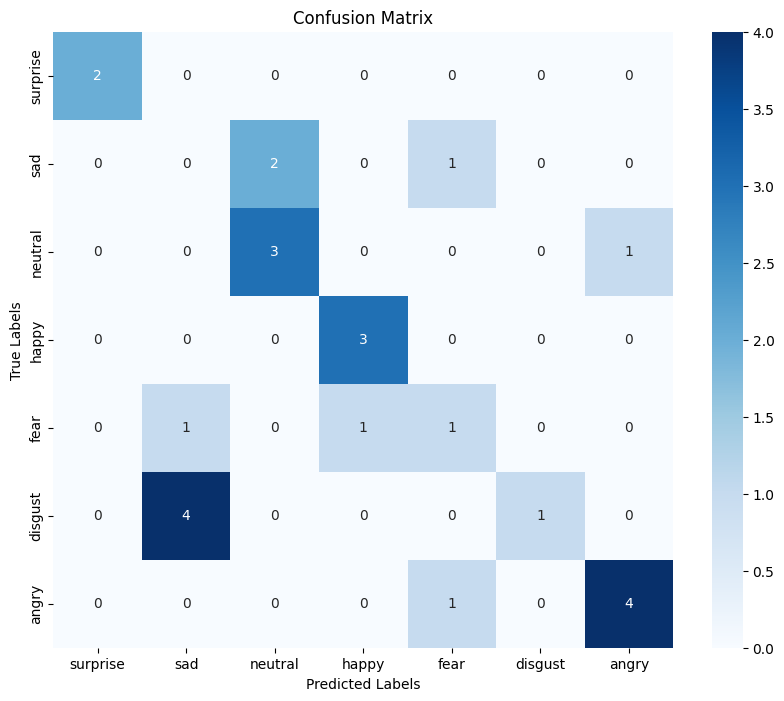

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Convert actual string labels to indices
actual_indices = [classes.index(label) for label in actual_labels]

# Convert predicted string labels to indices
predicted_indices = [classes.index(label) for label in predicted_labels]

# Calculate accuracy
accuracy = accuracy_score(actual_indices, predicted_indices)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Generate confusion matrix
cm = confusion_matrix(actual_indices, predicted_indices)

# Generate and print classification report
report = classification_report(actual_indices, predicted_indices, target_names=classes)
print(report)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


9406464/9406464 [==============================] - 0s 0us/step


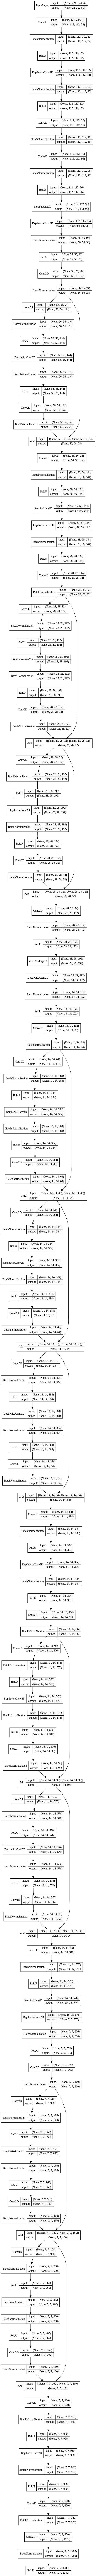

In [2]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import plot_model

# Create MobileNetV2 model
model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Plot the model architecture and save it to a file
plot_model(model, to_file='mobilenetv2_architecture.png', show_shapes=True, show_layer_names=False)
